In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3)

20

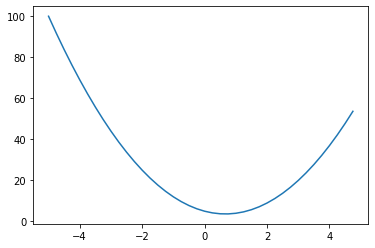

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.001
x = 3
(f(x+h) - f(x))/h

14.00300000000243

In [6]:
a = 2
b = -3
c = 10
d = a*b + c
print(d)

4


In [7]:
h = 0.0001
d1 = a*b + c
c += h
d2 = a*b + c
print(f'd1 = {d1}, d2 = {d2}')
print(f'slope is {(d2 - d1)/h}')

d1 = 4, d2 = 4.0001
slope is 0.9999999999976694


In [65]:

class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0 #the derivative of final output L with respect to value, assume no effect of gradient on init
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda : None

        
    def __repr__(self):
        return f'Value(data={self.data})'
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad


        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
        

    def __mul__(self, other):

        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out

    def __sub__(self, other):
        return self + (-other)

    def __neg__(self):
        return self * -1

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * (other ** -1)

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int and float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out
    

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp') 

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set() 
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v) 
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'
L

Value(data=-8.0)

In [1]:
from graphviz import Digraph


def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot



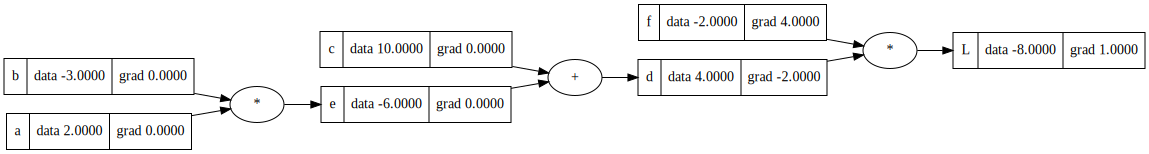

In [43]:
draw_dot(L)

In [33]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()


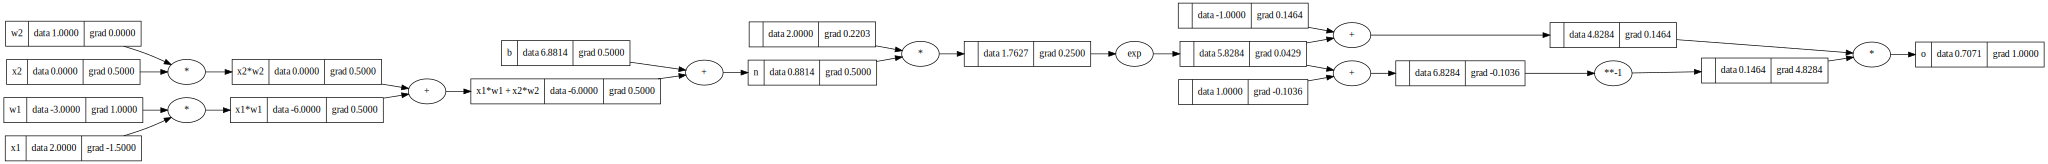

In [44]:
draw_dot(o)

In [43]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o = (e - 1) / (e + 1);
o.label = 'o'
o.backward()



In [46]:
import torch
import random

In [74]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [75]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)


Value(data=-0.19684929736529533)

In [87]:


xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]
ypred



[Value(data=0.38634889689406704),
 Value(data=-0.30816314549048424),
 Value(data=0.0017531358251868783),
 Value(data=-0.21420518441463235)]

In [77]:
n.parameters()

[Value(data=-0.5089366191798632),
 Value(data=0.9022094412419575),
 Value(data=0.1016776160440156),
 Value(data=0.7742122245184135),
 Value(data=0.49029687537588806),
 Value(data=0.5822158462062712),
 Value(data=-0.33881433583348697),
 Value(data=-0.6600377307838605),
 Value(data=0.36923801448755),
 Value(data=0.133051101395947),
 Value(data=0.822173642943655),
 Value(data=-0.9982615570881981),
 Value(data=0.7053634792167855),
 Value(data=-0.08286139896001643),
 Value(data=0.7077192517384996),
 Value(data=0.13529776333215926),
 Value(data=-0.4769724587138413),
 Value(data=0.7904962919601413),
 Value(data=0.14152103700547847),
 Value(data=0.9900379184880759),
 Value(data=0.4855515565592119),
 Value(data=0.8331918007463956),
 Value(data=-0.055265128181570145),
 Value(data=0.5907967578936741),
 Value(data=-0.13431660400239775),
 Value(data=-0.45464681292579656),
 Value(data=0.9188797161147022),
 Value(data=-0.20694234250510246),
 Value(data=-0.18505194251201718),
 Value(data=0.23448964140

In [88]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

loss


Value(data=3.333009484595716)

In [89]:
loss.backward()


In [72]:
n.layers[0].neurons[0].w[0].grad

0.09171733214104427

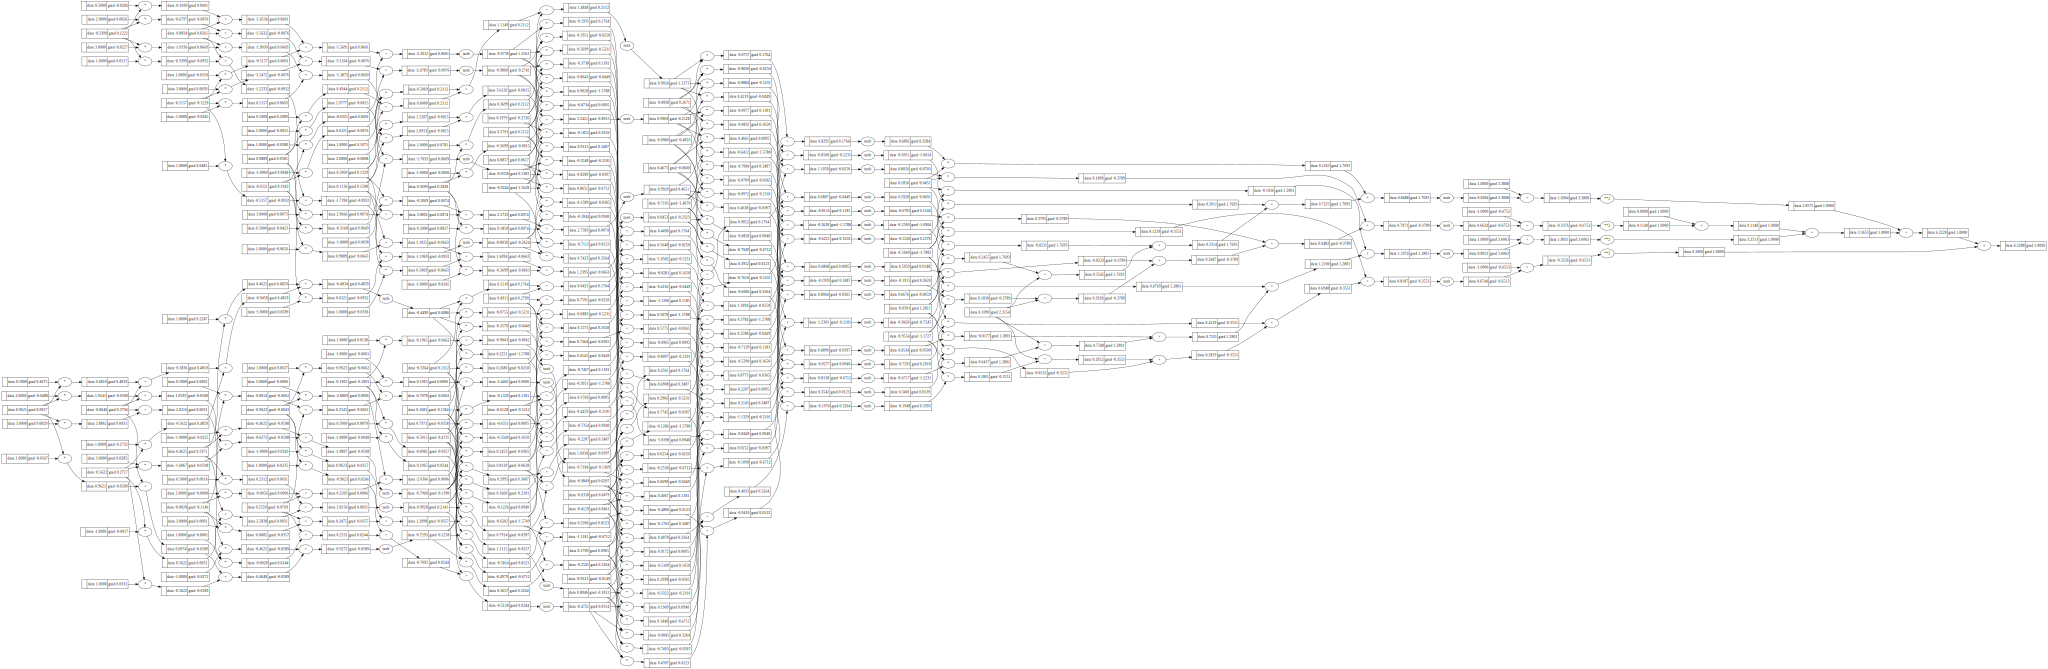

In [73]:
draw_dot(loss)


In [93]:
alpha = 0.01
for k in range(20):
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    for p in n.parameters():
      p.grad = 0
    loss.backward()

    for p in n.parameters():
        p.data -= alpha * p.grad
    print(f'loss = {loss.data:.4f}')

loss = 0.4007
loss = 0.3767
loss = 0.3548
loss = 0.3349
loss = 0.3166
loss = 0.2999
loss = 0.2846
loss = 0.2705
loss = 0.2575
loss = 0.2454
loss = 0.2343
loss = 0.2240
loss = 0.2144
loss = 0.2055
loss = 0.1971
loss = 0.1894
loss = 0.1821
loss = 0.1753
loss = 0.1689
loss = 0.1629


In [92]:
ypred


[Value(data=0.8193633007058485),
 Value(data=-0.6709953881889203),
 Value(data=-0.6787388758174138),
 Value(data=0.5720498639621242)]